### Import packages

In [1]:
import pandas as pd; import os; from analysis_helpers import *; import warnings
from analysis_helpers import *
warnings.filterwarnings('ignore')
import seaborn as sb
import numpy as np
from scipy.interpolate import pchip
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema
import numpy as np
import scipy as sp
from scipy.interpolate import interp1d
from scipy.signal import argrelextrema
import pingouin

### Load data

In [2]:
b     = pd.read_csv('behavioral.csv') 
d_nov = pd.read_csv('d_nov_b.csv')

### Add last-cued category to memory trials

In [3]:
for idx,x in b[(b['Trial']==9)&(b['Trial Type']=='Presentation')].iterrows():
    b.loc[(b['UniqueID']==x['UniqueID']) &
         (b['Run']==x['Run'])
         &(b['Trial Type']=='Memory'),'Cued Category'] = x['Cued Category']

In [4]:
b.loc[(b['Attention Level']=='Novel') & (b['Cued Category']=='Face' ) & (b['Category']=='Face' ), 'Attention Level'] = 'Novel_Cued_Cat'
b.loc[(b['Attention Level']=='Novel') & (b['Cued Category']=='Place') & (b['Category']=='Place'), 'Attention Level'] = 'Novel_Cued_Cat'
b.loc[(b['Attention Level']=='Novel') & (b['Cued Category']=='Face' ) & (b['Category']=='Place'), 'Attention Level'] = 'Novel_Uncued_Cat'
b.loc[(b['Attention Level']=='Novel') & (b['Cued Category']=='Place') & (b['Category']=='Face' ), 'Attention Level'] = 'Novel_Uncued_Cat'  

### Separate behavioral and variable

In [5]:
bvar = b[(b['UniqueID']>=30)] 
bsus = b[(b['UniqueID']<=29)] 

### All images, Variable --> significant effect of Category, Attention Level, and interaction

In [6]:
# Variable Attention

# groupby subject, attention level, category
bot = bvar.groupby(['UniqueID','Attention Level','Category'],as_index=False).mean()

# repeated measures anova --> familiarity_rating ~ category * attention_level
pingouin.rm_anova(dv='Familiarity Rating', within=['Category','Attention Level'], subject='UniqueID', 
                  data=bot)

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,Category,3.458,1,22,3.458,10.893,3.258622e-03,3.258622e-03,0.331,1.000
1,Attention Level,13.437,5,110,2.687,27.730,4.463426e-18,8.250565e-09,0.558,0.418
2,Category * Attention Level,1.500,5,110,0.300,8.183,1.344844e-06,6.410325e-05,0.271,0.644


### Follow up t-test (scene / face)

In [7]:
pingouin.pairwise_ttests(dv='Familiarity Rating', within=['Category','Attention Level'], subject='UniqueID', 
                         data=bot).head(n=1)

,Contrast,Category,A,B,Paired,Parametric,T,dof,tail,p-unc,BF10,CLES,hedges
0,Category,-,Face,Place,True,True,-6.057,136.0,two-sided,1.278449e-08,8.015e+05,0.617,-0.477


### Novel images, Variable --> Trending towards sig diff between categories (not attention level)

In [8]:
pingouin.pairwise_ttests(dv='Familiarity Rating', within=['Category'], subject='UniqueID', 
                         data=bot[(bot['Attention Level'].isin(['Novel_Cued_Cat','Novel_Uncued_Cat']))])

,Contrast,A,B,Paired,Parametric,T,dof,tail,p-unc,BF10,CLES,hedges
0,Category,Face,Place,True,True,-1.738,44.0,two-sided,0.089227,0.645,0.57,-0.237


### All images, Sustained --> significant effect of Category, Attention Level, and interaction

In [9]:
# # Sustained Attention

# # groupby subject, attention level, category
# bot = bsus.groupby(['UniqueID','Attention Level','Category'],as_index=False).mean()

# # repeated measures anova --> familiarity_rating ~ category * attention_level
# pingouin.rm_anova(dv='Familiarity Rating', within=['Category','Attention Level'], subject='UniqueID', 
#                   data=bot)

In [10]:
# ts = pingouin.pairwise_ttests(dv='Familiarity Rating', within=['Category','Attention Level'], subject='UniqueID',data=bot)
# ts[ts['p-unc']<.05]

### Novel images, Sustained --> Significant diff for attention level, and interaction, but not category alone

In [11]:
pingouin.rm_anova(dv='Familiarity Rating', within=['Category','Attention Level'], subject='UniqueID', 
                         data=bot[(bot['Attention Level'].isin(['Novel_Cued_Cat','Novel_Uncued_Cat']))])

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,Category,0.195,1,22,0.195,1.833,0.189540,0.189540,0.077,1.0
1,Attention Level,0.007,1,22,0.007,0.370,0.549419,0.549419,0.017,1.0
2,Category * Attention Level,0.004,1,22,0.004,0.240,0.628927,0.628927,0.011,1.0


In [12]:
pingouin.pairwise_ttests(dv='Familiarity Rating', within=['Category','Attention Level'], subject='UniqueID', 
                         data=bot[(bot['Attention Level'].isin(['Novel_Cued_Cat','Novel_Uncued_Cat']))])


,Contrast,Category,A,B,Paired,Parametric,T,dof,tail,p-unc,BF10,CLES,hedges
0,Category,-,Face,Place,True,True,-1.738,44.00,two-sided,0.089227,0.645,0.570,-0.237
1,Attention Level,-,Novel_Cued_Cat,Novel_Uncued_Cat,True,True,-0.602,44.00,two-sided,0.549962,0.192,0.520,-0.046
2,Category * Attention Level,Face,Novel_Cued_Cat,Novel_Uncued_Cat,True,True,-0.133,42.87,two-sided,0.894585,0.297,0.502,-0.039
3,Category * Attention Level,Place,Novel_Cued_Cat,Novel_Uncued_Cat,True,True,-0.218,43.00,two-sided,0.828223,0.301,0.538,-0.064


<hr>

# Behavioral recap

In both experiments, category, attention level, and interaction all influence familiarity.

#### Within novel images:

<b>variable:</b> only category has an influence.

<b>sustained:</b> only attention level and interaction have an influence?

<hr>

# Pupil data

In [5]:
d_nov['Experiment'] = np.nan
d_nov.loc[d_nov['UniqueID']<=29, 'Experiment'] = 'Sustained'
d_nov.loc[d_nov['UniqueID']>=30, 'Experiment'] = 'Variable'

### Plot all new images, grouped by experiment

Variable


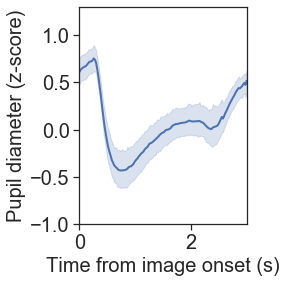

Sustained


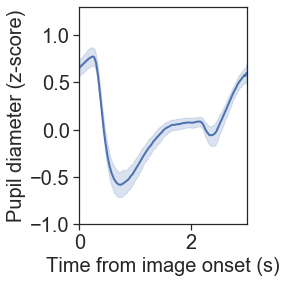

In [41]:
attn_group = d_nov.groupby(['Experiment','UniqueID','Time','Attention Level'], as_index=False).mean()

for e in ['Variable', 'Sustained']:
 
    #for level in ['Place','Face']:

    plt.figure(figsize=(3, 4));  #;print(level)

    sb.lineplot(x='Time', y='Interp', #hue='Familiarity Instruction', 
                data=attn_group[(attn_group['Experiment']==e)
                               &(attn_group['Attention Level'].isin(['Novel_Cued_Cat','Novel_Uncued_Cat']))].groupby(['UniqueID','Time'], as_index=False).mean(), 
                linewidth = 2, palette="RdBu")

    plt.xlim((0 , 3)); plt.ylim((-1, 1.3)); plt.tick_params(labelsize=20)
    plt.xlabel("Time from image onset (s)", size = 20); plt.ylabel("Pupil diameter (z-score)", size = 20)


    name = e+'_all.pdf'
    plt.savefig(name)
    print(e)
    plt.show()

### Plot all new images, both exps, grouped by rating and category

Variable
Place


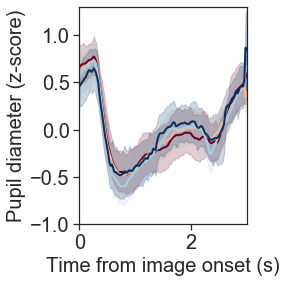

Variable
Face


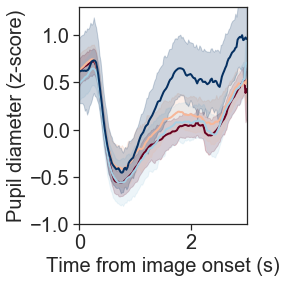

Sustained
Place


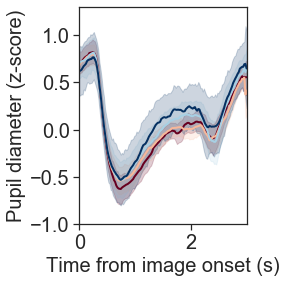

Sustained
Face


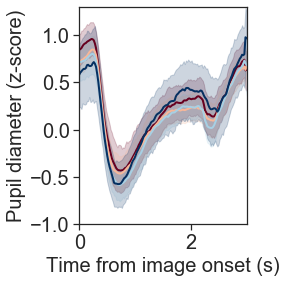

In [45]:
attn_group = d_nov.groupby(['Experiment','UniqueID','Familiarity Rating','Time','Category'], as_index=False).mean()

for e in ['Variable', 'Sustained']:
 
    for level in ['Place','Face']:

        plt.figure(figsize=(3, 4)); print(e);print(level)
 
        sb.lineplot(x='Time', y='Interp', hue='Familiarity Rating', 
                    data=attn_group[(attn_group['Experiment']==e)&(attn_group['Category'] == level)], 
                    linewidth = 2, palette="RdBu", legend=False)
                
        plt.xlim((0 , 3)); plt.ylim((-1, 1.3)); plt.tick_params(labelsize=20)
        plt.xlabel("Time from image onset (s)", size = 20); plt.ylabel("Pupil diameter (z-score)", size = 20)
        
        name = e+'_'+level+'.pdf'
        plt.savefig(name)
        plt.show()

### Sustained Attention plots, split by rating, category, and attention cue

Sustained
Novel_Cued_Cat
Place


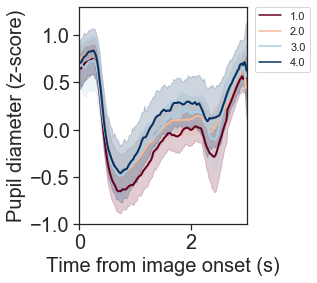

Sustained
Novel_Uncued_Cat
Place


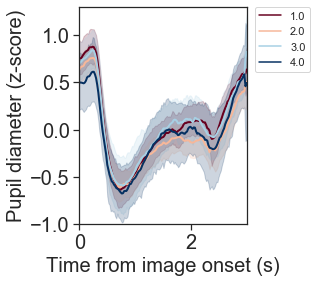

Sustained
Novel_Cued_Cat
Face


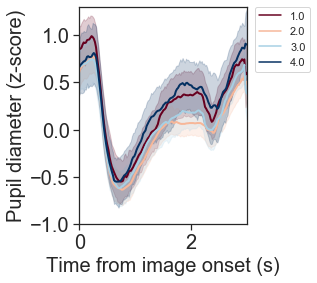

Sustained
Novel_Uncued_Cat
Face


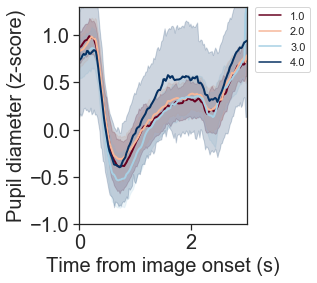

In [43]:
attn_group = d_nov.groupby(['Experiment','UniqueID','Familiarity Rating','Time','Category','Attention Level'], as_index=False).mean()

for e in ['Sustained']:
 
    for level in ['Place','Face']:
        for c in ['Novel_Cued_Cat','Novel_Uncued_Cat']:
            
            missing_subs = []

            plt.figure(figsize=(3, 4)); print(e);print(c);print(level)

            sb.lineplot(x='Time', y='Interp', hue='Familiarity Rating', 
                        data=attn_group[(attn_group['Experiment']==e)&(attn_group['Category'] == level)
                                       &(attn_group['Attention Level']==c)], 
                        linewidth = 2, palette="RdBu")

            plt.xlim((0 , 3)); plt.ylim((-1, 1.3)); plt.tick_params(labelsize=20)
            plt.xlabel("Time from image onset (s)", size = 20); plt.ylabel("Pupil diameter (z-score)", size = 20)

            plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
            fig_name = e+'_'+level+'_'+c+'.pdf'

            plt.savefig(fig_name)
            plt.show()

### Organize gaze data for analysis 

In [4]:
var_lme = d_nov[d_nov['Experiment']=='Variable'].groupby(['UniqueID', 'Category','Familiarity Rating'], as_index=False).mean()
var_lme['FA'] = var_lme['Familiarity Rating']
var_lme = var_lme[['UniqueID', 'Category','FA','Interp']] 

sus_lme = d_nov[d_nov['Experiment']=='Sustained'].groupby(['UniqueID', 'Category','Attention Level','Familiarity Rating'], as_index=False).mean()
sus_lme['FA'] = sus_lme['Familiarity Rating']
sus_lme['AT'] = sus_lme['Attention Level']
sus_lme = sus_lme[['UniqueID', 'Category','FA','Interp','AT']]

### Load R and packages

In [5]:
import rpy2.robjects as robjects
%load_ext rpy2.ipython

In [6]:
%%R
library(pacman)
pacman::p_load(lme4, lmerTest, emmeans, sjPlot, sjmisc, sjlabelled, MASS, memisc, lsmeans, dplyr, mice, mitml, multcomp)

### Load data into R

In [7]:
%R -i var_lme

In [8]:
%%R 
var_lme$FA <- var_lme$FA<-as.factor(var_lme$FA)
var_model <- lmer(Interp~FA*Category+(1|UniqueID), data=var_lme)
summary(var_model)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: Interp ~ FA * Category + (1 | UniqueID)
   Data: var_lme

REML criterion at convergence: 196.2

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.0414 -0.6004 -0.1374  0.4095  4.2501 

Random effects:
 Groups   Name        Variance Std.Dev.
 UniqueID (Intercept) 0.03356  0.1832  
 Residual             0.15271  0.3908  
Number of obs: 166, groups:  UniqueID, 23

Fixed effects:
                   Estimate Std. Error        df t value Pr(>|t|)   
(Intercept)         0.03702    0.09832 129.02043   0.377  0.70711   
FA2                 0.08869    0.12286 129.20973   0.722  0.47166   
FA3                 0.01207    0.12561 128.35626   0.096  0.92359   
FA4                 0.33240    0.12561 128.35626   2.646  0.00916 **
CategoryPlace      -0.01857    0.12400 127.79339  -0.150  0.88117   
FA2:CategoryPlace  -0.08337    0.17136 128.98333  -0.487  0.62744   
FA3:CategoryPlace  -0.03554   

### Variable Attn model summary

In [9]:
%%R
a<- summary(var_model)
coef(summary(var_model))

                     Estimate Std. Error       df     t value    Pr(>|t|)
(Intercept)        0.03702497 0.09832088 129.0204  0.37657283 0.707109659
FA2                0.08869416 0.12286287 129.2097  0.72189560 0.471663063
FA3                0.01207124 0.12560866 128.3563  0.09610194 0.923589496
FA4                0.33240268 0.12560866 128.3563  2.64633573 0.009155017
CategoryPlace     -0.01857323 0.12399717 127.7934 -0.14978757 0.881168362
FA2:CategoryPlace -0.08336657 0.17135925 128.9833 -0.48650172 0.627437096
FA3:CategoryPlace -0.03554074 0.17412930 127.5942 -0.20410544 0.838596293
FA4:CategoryPlace -0.33453678 0.17436114 128.5557 -1.91864306 0.057246430


### Post-hoc test of interactions

In [33]:
# %%R
# lsmeans(var_model, pairwise ~ FA, ddf="Satterthwaite")

In [22]:
%%R
lsmeans(var_model, pairwise ~ Category:FA, ddf="Satterthwaite")

$lsmeans
 Category FA   lsmean     SE  df lower.CL upper.CL
 Face     1   0.03703 0.0984 138  -0.1576    0.232
 Place    1   0.01845 0.0941 133  -0.1676    0.204
 Face     2   0.12572 0.0920 131  -0.0562    0.308
 Place    2   0.02378 0.0919 132  -0.1581    0.206
 Face     3   0.04910 0.0962 136  -0.1411    0.239
 Place    3  -0.00502 0.0941 133  -0.1911    0.181
 Face     4   0.36943 0.0962 136   0.1793    0.560
 Place    4   0.01632 0.0939 134  -0.1695    0.202

Degrees-of-freedom method: kenward-roger 
Confidence level used: 0.95 

$contrasts
 contrast          estimate    SE  df t.ratio p.value
 Face 1 - Place 1   0.01857 0.124 138  0.150  1.0000 
 Face 1 - Face 2   -0.08869 0.123 139 -0.722  0.9962 
 Face 1 - Place 2   0.01325 0.123 139  0.108  1.0000 
 Face 1 - Face 3   -0.01207 0.126 138 -0.096  1.0000 
 Face 1 - Place 3   0.04204 0.124 138  0.339  1.0000 
 Face 1 - Face 4   -0.33240 0.126 138 -2.645  0.1491 
 Face 1 - Place 4   0.02071 0.124 139  0.166  1.0000 
 Place 1 - Face 

### Plot residuals, Variable Attention model

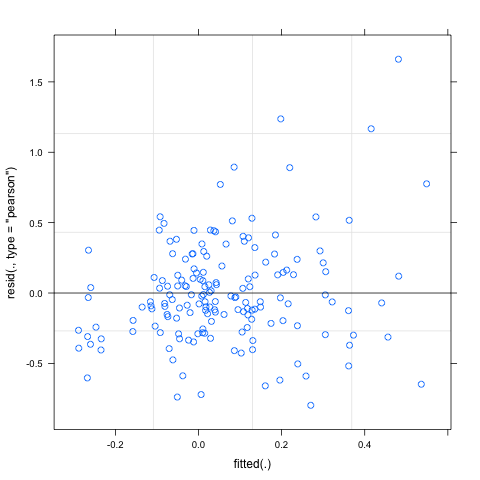

In [13]:
%%R
plot(var_model)

### Sustained Attention, liner mixed model 

In [18]:
%R -i sus_lme

In [19]:
%%R
sus_lme$FA <- as.factor(sus_lme$FA)
sus_model  <- lmer(Interp~Category*FA+Category*AT+(1|UniqueID), data=sus_lme)
coef(summary(sus_model))

                                     Estimate Std. Error       df     t value
(Intercept)                       0.163470490 0.07793174 335.4367  2.09761111
CategoryPlace                    -0.122114296 0.10603242 371.4339 -1.15166946
FA2                              -0.075181438 0.09156339 370.6531 -0.82108622
FA3                              -0.084799649 0.09435470 373.7619 -0.89873262
FA4                               0.084664341 0.10737601 381.1951  0.78848468
ATNovel_Uncued_Cat                0.147559533 0.06957823 371.8499  2.12077170
CategoryPlace:FA2                 0.093592229 0.12980897 370.0388  0.72099969
CategoryPlace:FA3                 0.157550609 0.13288966 371.0027  1.18557467
CategoryPlace:FA4                -0.002940386 0.14803923 373.3996 -0.01986221
CategoryPlace:ATNovel_Uncued_Cat -0.232023229 0.09735313 371.4706 -2.38331549
                                   Pr(>|t|)
(Intercept)                      0.03668748
CategoryPlace                    0.25019768
FA2       

In [30]:
%%R
lsmeans(sus_model, pairwise ~ AT)

R[write to console]: NOTE: Results may be misleading due to involvement in interactions



$lsmeans
 AT               lsmean     SE   df lower.CL upper.CL
 Novel_Cued_Cat    0.115 0.0406 62.4   0.0335    0.196
 Novel_Uncued_Cat  0.146 0.0424 72.0   0.0616    0.231

Results are averaged over the levels of: Category, FA 
Degrees-of-freedom method: kenward-roger 
Confidence level used: 0.95 

$contrasts
 contrast                          estimate     SE  df t.ratio p.value
 Novel_Cued_Cat - Novel_Uncued_Cat  -0.0315 0.0487 373 -0.648  0.5176 

Results are averaged over the levels of: Category, FA 
Degrees-of-freedom method: kenward-roger 



In [31]:
%%R
lsmeans(sus_model, pairwise ~ AT*Category)

$lsmeans
 AT               Category   lsmean     SE  df lower.CL upper.CL
 Novel_Cued_Cat   Face     0.144641 0.0533 156   0.0394    0.250
 Novel_Uncued_Cat Face     0.292201 0.0561 179   0.1816    0.403
 Novel_Cued_Cat   Place    0.084578 0.0521 149  -0.0184    0.188
 Novel_Uncued_Cat Place    0.000114 0.0548 168  -0.1080    0.108

Results are averaged over the levels of: FA 
Degrees-of-freedom method: kenward-roger 
Confidence level used: 0.95 

$contrasts
 contrast                                       estimate     SE  df t.ratio
 Novel_Cued_Cat Face - Novel_Uncued_Cat Face     -0.1476 0.0696 372 -2.120 
 Novel_Cued_Cat Face - Novel_Cued_Cat Place       0.0601 0.0672 372  0.893 
 Novel_Cued_Cat Face - Novel_Uncued_Cat Place     0.1445 0.0692 371  2.088 
 Novel_Uncued_Cat Face - Novel_Cued_Cat Place     0.2076 0.0694 373  2.990 
 Novel_Uncued_Cat Face - Novel_Uncued_Cat Place   0.2921 0.0713 371  4.096 
 Novel_Cued_Cat Place - Novel_Uncued_Cat Place    0.0845 0.0681 372  1.240 
 p.va

### Plot residuals, Sustained Attention model

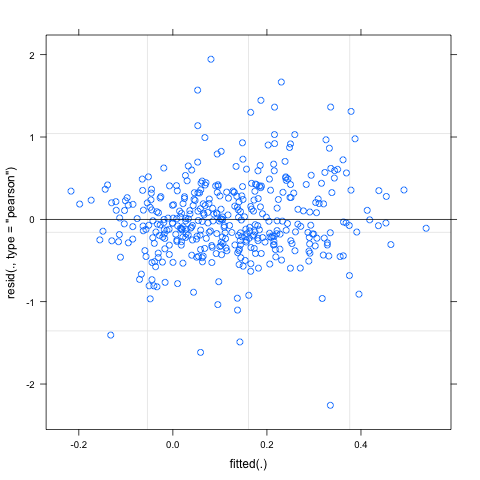

In [17]:
%%R
plot(sus_model)

### Make table

In [35]:
%%R
tab_model(var_model, sus_model, p.val = "satterthwaite", show.df = TRUE,  show.p = TRUE,
  show.stat = TRUE, show.fstat=TRUE)

In [36]:
%%R
coef(summary(var_model))

                     Estimate Std. Error       df     t value    Pr(>|t|)
(Intercept)        0.03702497 0.09832088 129.0204  0.37657283 0.707109659
FA2                0.08869416 0.12286287 129.2097  0.72189560 0.471663063
FA3                0.01207124 0.12560866 128.3563  0.09610194 0.923589496
FA4                0.33240268 0.12560866 128.3563  2.64633573 0.009155017
CategoryPlace     -0.01857323 0.12399717 127.7934 -0.14978757 0.881168362
FA2:CategoryPlace -0.08336657 0.17135925 128.9833 -0.48650172 0.627437096
FA3:CategoryPlace -0.03554074 0.17412930 127.5942 -0.20410544 0.838596293
FA4:CategoryPlace -0.33453678 0.17436114 128.5557 -1.91864306 0.057246430
